In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [7]:
import torchvision.datasets
import torch.utils.data

In [61]:
batch_size = 4
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
dataloader = iter(trainloader)
images, labels = next(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['truck', 'dog', 'deer', 'frog']


<Figure size 640x480 with 0 Axes>

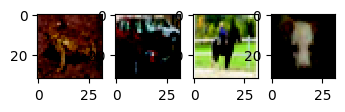

In [41]:

plt.figure()

fig = plt.figure(figsize=(32, 32))
for i in range(4):
    sub = fig.add_subplot(32, 32, i+1)
    im2display = np.transpose(images[i], (1, 2, 0))
    sub.imshow(im2display, interpolation='nearest')
print([classes[i] for i in labels])

In [44]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, data):
        l1 = self.pool(F.relu(self.conv1(data)))
        l2 = self.pool(F.relu(self.conv2(l1)))
        x = torch.flatten(l2, 1)
        f1 = F.relu(self.fc1(x))
        f2 = F.relu(self.fc2(f1))
        f3 = self.fc3(f2)
        return f3
    
net = Net()

In [45]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [46]:
for epoch in range(2):
    
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        
        inp, labels = data
        optimizer.zero_grad()

        outp = net(inp)
        loss = criterion(outp, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print("EPOCH:", epoch, "i:", i, "LOSS:", running_loss/2000)
            running_loss = 0


EPOCH: 0 i: 1999 LOSS: 2.1847221181094647
EPOCH: 0 i: 3999 LOSS: 1.81593220692873
EPOCH: 0 i: 5999 LOSS: 1.659810152053833
EPOCH: 0 i: 7999 LOSS: 1.576831332013011
EPOCH: 0 i: 9999 LOSS: 1.4980725589096546
EPOCH: 0 i: 11999 LOSS: 1.449043179050088
EPOCH: 1 i: 1999 LOSS: 1.389036149032414
EPOCH: 1 i: 3999 LOSS: 1.3791919244229793
EPOCH: 1 i: 5999 LOSS: 1.327756078420207
EPOCH: 1 i: 7999 LOSS: 1.2939119963217527
EPOCH: 1 i: 9999 LOSS: 1.3046227396018804
EPOCH: 1 i: 11999 LOSS: 1.2966619028039277


In [49]:
PATH = './cifar_net_path'
torch.save(net.state_dict(), PATH)

In [63]:
loaded_net = Net()
loaded_net.load_state_dict(torch.load(PATH))

testdataloader = iter(testloader)
data, labels = next(testdataloader)
with torch.no_grad():
    out = loaded_net(data)
    


torch.Size([4, 3, 32, 32])
torch.Size([4, 10])


In [64]:
def display_images(images, labels):
    plt.figure()

    fig = plt.figure(figsize=(32, 32))
    for i in range(4):
        sub = fig.add_subplot(32, 32, i+1)
        im2display = np.transpose(images[i], (1, 2, 0))
        sub.imshow(im2display, interpolation='nearest')
    print([classes[i] for i in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['frog', 'truck', 'truck', 'deer']


<Figure size 640x480 with 0 Axes>

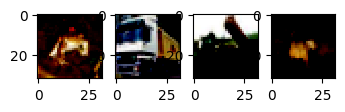

In [65]:
display_images(data, labels)

In [69]:
print([classes[i] for i in torch.argmax(out, dim=1)])
print(labels.shape)
print(torch.argmax(out, dim=1).shape)

['frog', 'truck', 'truck', 'deer']
torch.Size([4])
torch.Size([4])


In [77]:
correct = 0
total = 0
confusion_matrix = np.zeros((len(classes), len(classes)))
correct_pred = [0 for c in classes]
total_pred = [0 for c in classes]
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader, 0):
        
        out = loaded_net(inputs)
        y_hat = torch.argmax(out, dim=1)
        num_correct = (y_hat == labels).sum()
        correct += num_correct
        total += 4
        for pred, truth in zip(y_hat, labels):
            if pred == truth:
                correct_pred[pred] += 1
            total_pred[truth] += 1
print(correct, total, correct/total)
for i, c in enumerate(classes, 0):
    print(c, correct_pred[i]/total_pred[i])
        

tensor(29046) 50000 tensor(0.5809)
plane 0.6198
car 0.7576
bird 0.4034
cat 0.342
deer 0.4948
dog 0.4654
frog 0.7164
horse 0.5882
ship 0.7374
truck 0.6842
